In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import gc
#import pingouin
from scipy.stats import chi2_contingency

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
populationFile = '/content/drive/MyDrive/Team 55 [NEW]/Data/Clean Data/Population_FullClean.csv'
povertyFile = '/content/drive/MyDrive/Team 55 [NEW]/Data/Clean Data/Poverty_FullClean.csv'
medianIncomeFile = '/content/drive/MyDrive/Team 55 [NEW]/Data/Clean Data/Median_Income_FullClean.csv'
povertyPercentFile = '/content/drive/MyDrive/Team 55 [NEW]/Data/Clean Data/Poverty_Percent_FullClean.csv'

#create dfs
population_df_original = pd.read_csv(populationFile)
poverty_df_original = pd.read_csv(povertyFile)
median_income_df_original = pd.read_csv(medianIncomeFile)
poverty_percent_df_original = pd.read_csv(povertyPercentFile)

In [ ]:
census_df = [population_df_original,poverty_df_original,median_income_df_original,poverty_percent_df_original]
census_names = ['population','poverty','Median_income','Poverty%']
clean_cesnsus_df = []
i = 0
for old in census_df:
  df = old.copy(deep = True)
  df = df.transpose()
  df.columns = df.iloc[0]
  df = df.drop(population_df.index[0])
  df['Year'] = df.index
  df = df.melt(id_vars=["Year"], var_name="County", value_name = census_names[i])
  i += 1
  clean_cesnus_df.append(df)

In [ ]:
population_df = population_df_original.copy(deep = True)
population_df = population_df.transpose()
population_df.columns = population_df.iloc[0]
population_df = population_df.drop(population_df.index[0])
population_df['Year'] = population_df.index
population_df = population_df.melt(id_vars=["Year"], var_name="County", value_name="population")


In [ ]:
poverty_df = poverty_df_original.copy(deep = True)
poverty_df = poverty_df.transpose()
poverty_df.columns = poverty_df.iloc[0]
poverty_df = poverty_df.drop(poverty_df.index[0])
poverty_df['Year'] = poverty_df.index
poverty_df = poverty_df.melt(id_vars=["Year"], var_name="County", value_name="poverty")


In [ ]:
median_income_df = median_income_df_original.copy(deep = True)
median_income_df = median_income_df.transpose()
median_income_df.columns = median_income_df.iloc[0]
median_income_df = median_income_df.drop(median_income_df.index[0])
median_income_df['Year'] = median_income_df.index
median_income_df = median_income_df.melt(id_vars=["Year"], var_name="County", value_name="Median_income")


In [ ]:
poverty_percent_df = poverty_percent_df_original.copy(deep = True)
poverty_percent_df = poverty_percent_df.transpose()
poverty_percent_df.columns = poverty_percent_df.iloc[0]
poverty_percent_df = poverty_percent_df.drop(poverty_percent_df.index[0])
poverty_percent_df['Year'] = poverty_percent_df.index
poverty_percent_df = poverty_percent_df.melt(id_vars=["Year"], var_name="County", value_name="Poverty%")


In [ ]:
#CENSUS CENSUS CENSUS CENSUS

#fast way to merge
#merged = pd.concat([population_df,poverty_df,median_income_df,poverty_percent_df], axis = 1)
#merged = merged.loc[:,~merged.columns.duplicated()]
#merged


#alternate merge method
census_merged = population_df.merge(poverty_df, on=['Year','County'], how='left')
census_merged = census_merged.merge(median_income_df, on=['Year','County'], how='left')
census_merged = census_merged.merge(poverty_percent_df, on=['Year','County'], how='left')

census_merged["Year"] = census_merged["Year"].astype(int)

census_merged

,Year,County,population,poverty,Median_income,Poverty%
0,2000,Ascension Parish,76639,8282,45398,10.5
1,2001,Ascension Parish,79210,8817,44933,10.9
2,2002,Ascension Parish,81379,8774,46214,10.4
3,2003,Ascension Parish,83967,9883,47959,11.4
4,2004,Ascension Parish,86352,10844,48789,12.0
...,...,...,...,...,...,...
415,2016,West Feliciana Parish,15322,2372,56459,23.7
416,2017,West Feliciana Parish,15373,2113,56584,21.0
417,2018,West Feliciana Parish,15474,2470,60296,24.4
418,2019,West Feliciana Parish,15570,2261,65296,22.1


In [ ]:
#ZILLOW ZILLOW ZILLOW ZILLOW  ZILLOW ZILLOW 

#this is for all homes zillow data
#not sure if we need to do zillow_bedroom count or 
#single family homes


  
df = pd.read_csv("/content/drive/MyDrive/Team 55 [NEW]/Data/zillow_data_update/zillow_all_homes.csv")
#drop useless columns: RegionID, RegionType, StateName, State, Metro, StateCodeFIPS, MunicipalCodeFIPS, tier
df.drop(columns=["RegionID", "RegionType", "StateName", "State", "Metro", "StateCodeFIPS", "MunicipalCodeFIPS", "tier"], inplace=True)
keyCounty = ["Washington Parish", "Orleans Parish", "St. Bernard Parish", "St. Charles Parish", "Jefferson Parish", "Plaquemines Parish", "St. James Parish", "St. John the Baptist Parish", "St. Tammany Parish", "Tangipahoa Parish", "Ascension Parish", "East Baton Rouge Parish", "East Feliciana Parish", "Iberville Parish", "Livingston Parish", "Pointe Coupee Parish", "St. Helena Parish", "West Baton Rouge Parish", "West Feliciana Parish", "Caddo Parish"]
keyCounty = pd.Series(keyCounty).str.replace("St.", "Saint", regex = False).tolist()

df = df[df["RegionName"].isin(keyCounty)]
df.rename(columns = {'RegionName':'County', 'Date':'Year'}, inplace = True)

df["Year"] = pd.DatetimeIndex(df['Year']).year.astype(int)

#Relevant zillow data of home value
zillow_homes_median =  df.dropna().groupby(["County","Year"]).median().reset_index() #median value
zillow_homes_mean =  df.dropna().groupby(["County","Year"]).mean().reset_index() #mean value
#convert saint in parish to St. to be able to merge with the census data
zillow_homes_median["County"] = zillow_homes_median["County"].str.replace("Saint", "St.")
zillow_homes_mean["County"] = zillow_homes_mean["County"].str.replace("Saint", "St.")

zillow_homes_mean


,County,Year,SizeRank,Value
0,Ascension Parish,2009,514.0,208125.851852
1,Ascension Parish,2010,514.0,206924.027778
2,Ascension Parish,2011,514.0,199271.638889
3,Ascension Parish,2012,514.0,191265.555556
4,Ascension Parish,2013,514.0,204453.944444
...,...,...,...,...
328,West Feliciana Parish,2018,2071.0,254010.750000
329,West Feliciana Parish,2019,2071.0,261487.055556
330,West Feliciana Parish,2020,2071.0,274115.935484
331,West Feliciana Parish,2021,2071.0,268986.083333


In [ ]:
## ZHVI ~ zillow home value index
census_zillow_merge_median = zillow_homes_median.merge(census_merged, on=['Year','County'], how='left')
census_zillow_merge_median.rename(columns = {'Value':'ZHVI'}, inplace = True)
census_zillow_merge_median = census_zillow_merge_median.sort_values(by='Year').reset_index(drop=True)
census_zillow_merge_median

,County,Year,SizeRank,ZHVI,population,poverty,Median_income,Poverty%
0,St. Charles Parish,2000,950.0,118554.5,48019,5598,45786,11.6
1,St. Bernard Parish,2000,1044.0,93575.5,67230,8553,35711,13.0
2,Orleans Parish,2000,178.0,129889.5,484692,114619,27788,24.8
3,Jefferson Parish,2000,160.0,154157.0,455406,60550,37695,13.5
4,Jefferson Parish,2001,160.0,161700.0,453154,66917,37101,15.0
...,...,...,...,...,...,...,...,...
328,East Baton Rouge Parish,2022,158.0,230832.0,NaN,NaN,NaN,NaN
329,St. Tammany Parish,2022,265.0,288745.5,NaN,NaN,NaN,NaN
330,Caddo Parish,2022,274.0,133693.0,NaN,NaN,NaN,NaN
331,West Baton Rouge Parish,2022,1560.0,226173.0,NaN,NaN,NaN,NaN


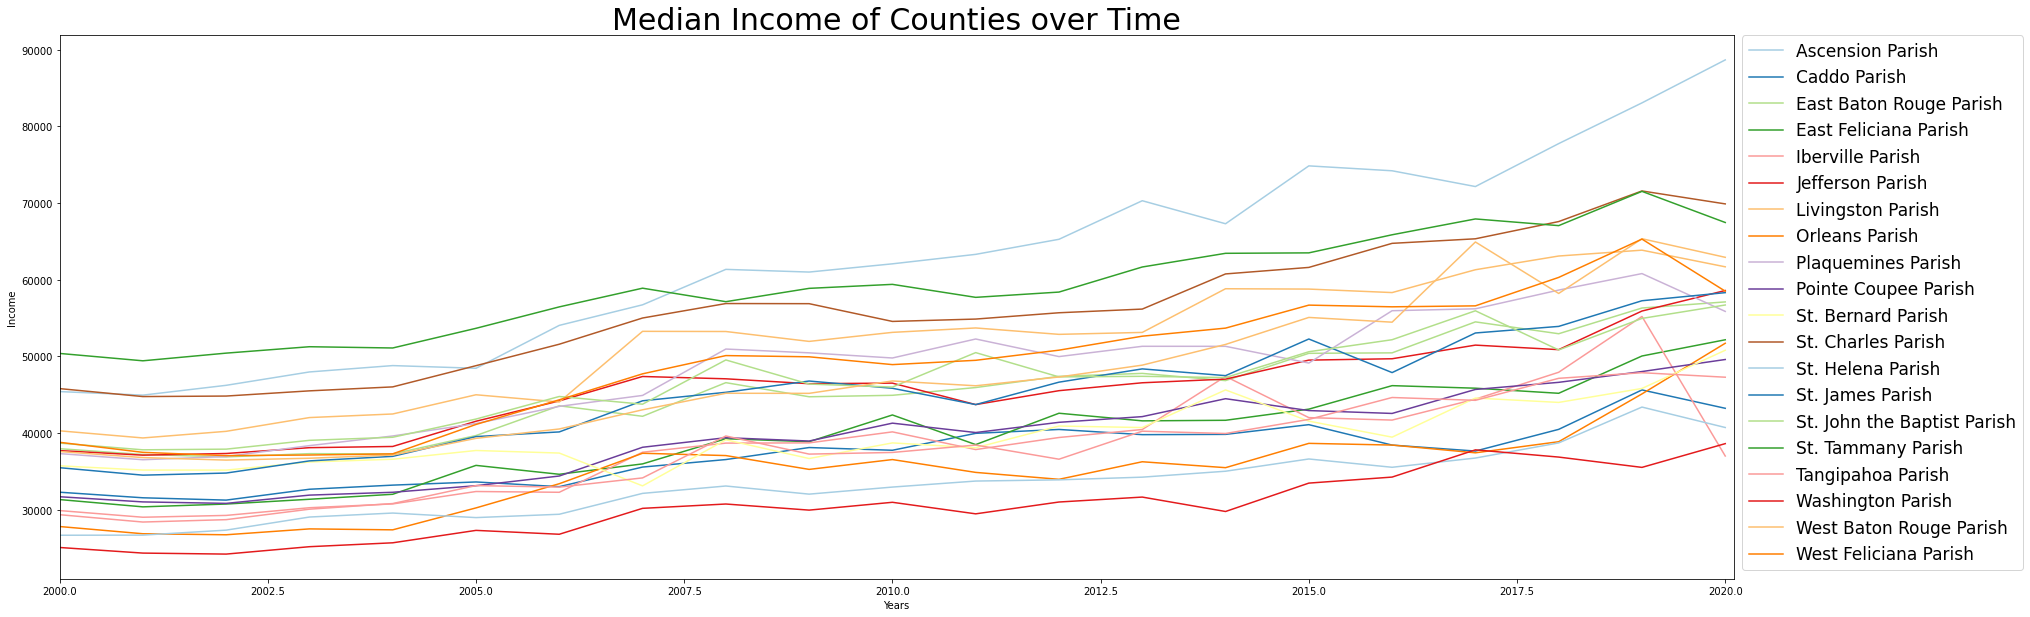

In [ ]:
#plot of Median Income
fig, ax = plt.subplots(figsize=(30,10))
ax.set(xlabel='Years', ylabel='Income',xlim=(2000,2020.1))
ax.set_title( label='Median Income of Counties over Time', fontsize=30)
sns.lineplot(x='Year',y='Median_income',data = census_merged, hue = 'County', palette="Paired", ax=ax)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0., fontsize=17)

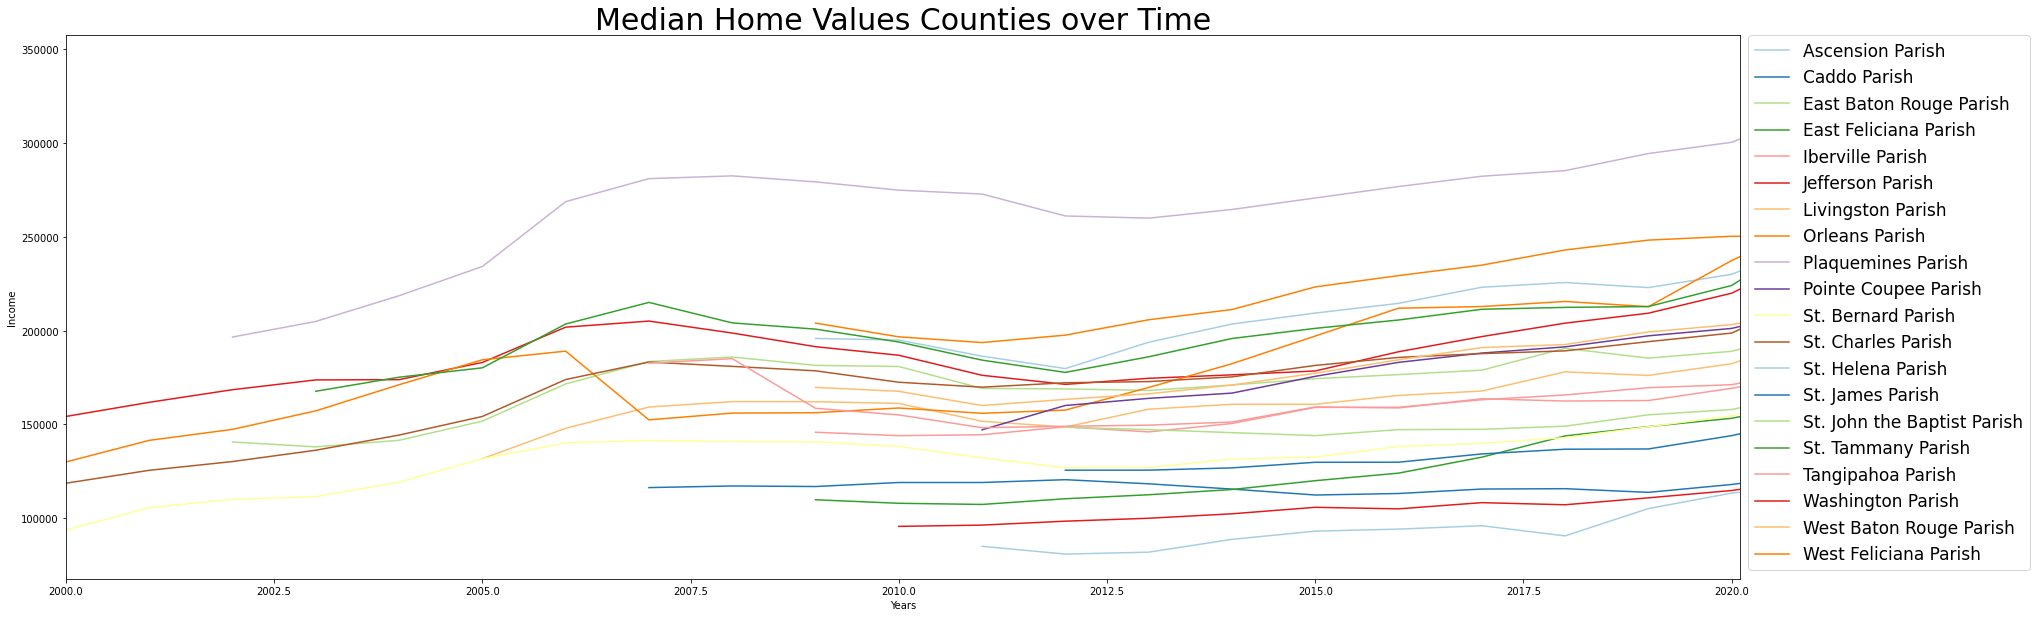

In [ ]:
#plot of Zillow Median Home Value
fig, ax = plt.subplots(figsize=(30,10))
ax.set(xlabel='Years', ylabel='Income',xlim=(2000,2020.1))
ax.set_title( label='Median Home Values Counties over Time', fontsize=30)
sns.lineplot(x='Year',y='Value',data = zillow_homes_median, hue = 'County', palette="Paired", ax=ax)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0., fontsize=17)

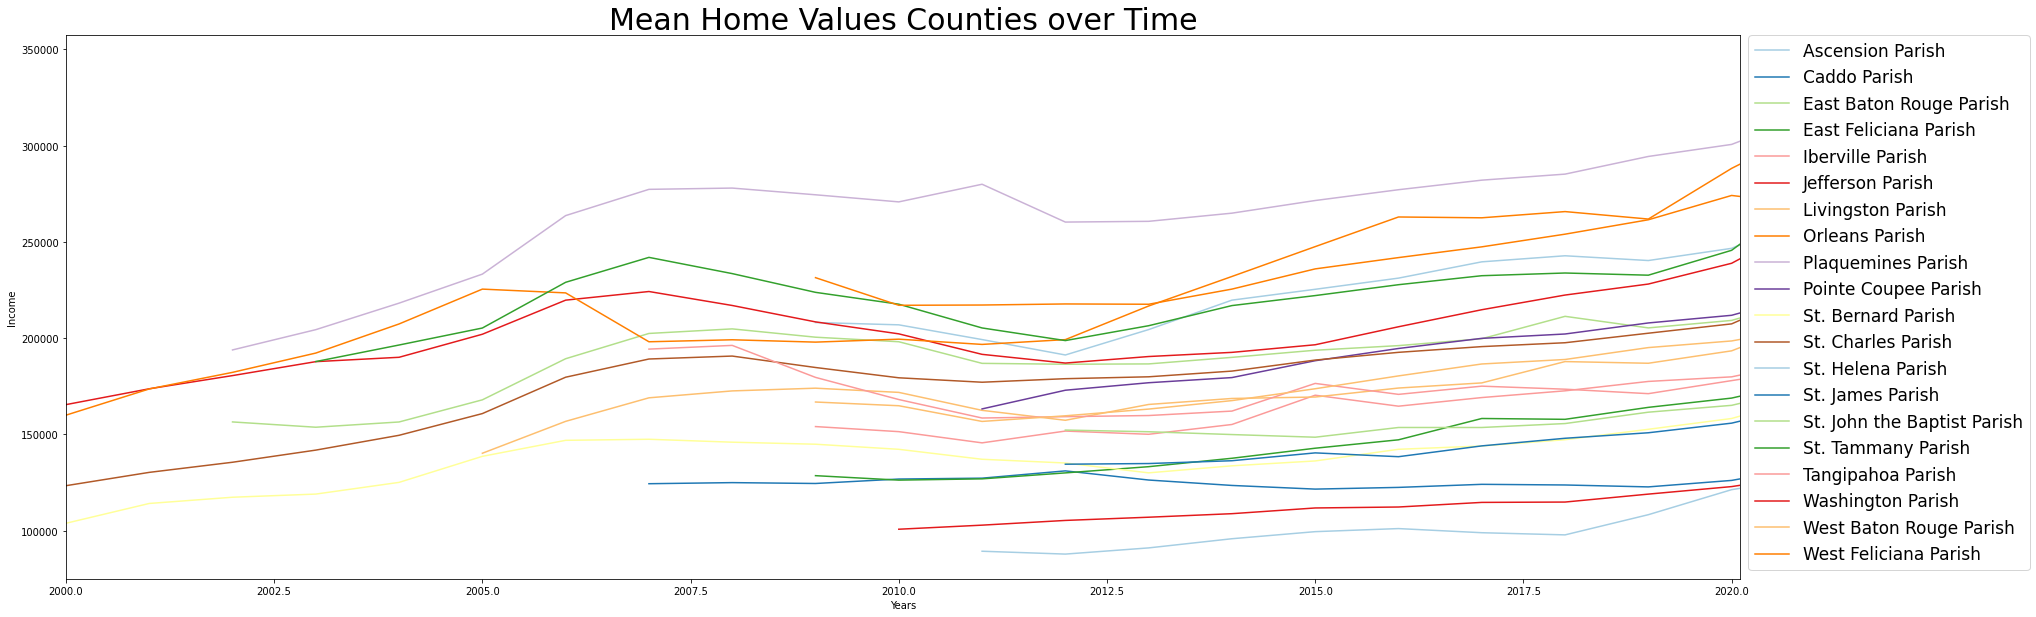

In [ ]:
#plot of Zillow Mean Home Value
fig, ax = plt.subplots(figsize=(30,10))
ax.set(xlabel='Years', ylabel='Income',xlim=(2000,2020.1))
ax.set_title( label='Mean Home Values Counties over Time', fontsize=30)
sns.lineplot(x='Year',y='Value',data = zillow_homes_mean, hue = 'County', palette="Paired", ax=ax)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0., fontsize=17)

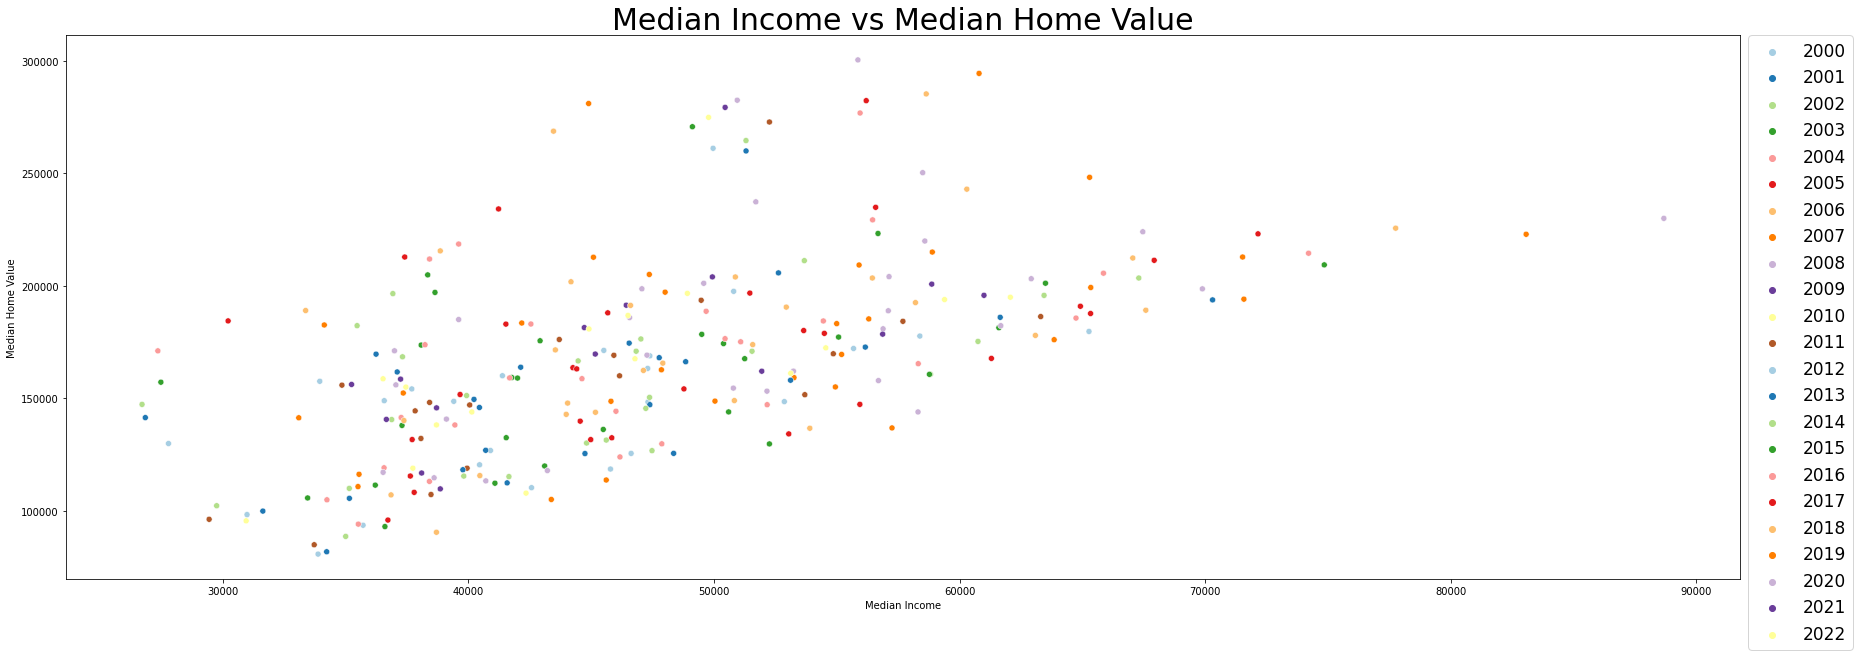

In [ ]:
#plot of Zillow Mean Home Value
fig, ax = plt.subplots(figsize=(30,10))
ax.set(xlabel='Median Income', ylabel='Median Home Value')#,xlim=(2000,2020.1))
ax.set_title( label='Median Income vs Median Home Value', fontsize=30)
sns.scatterplot(x='Median_income',y='ZHVI',data = census_zillow_merge_median, hue = 'Year', palette="Paired", ax=ax)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0., fontsize=17)

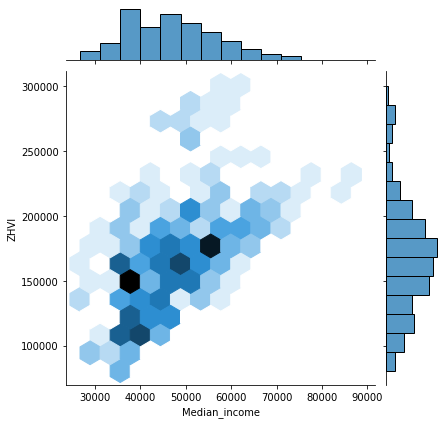

In [ ]:
sns.jointplot(x='Median_income',y='ZHVI',data = census_zillow_merge_median, kind='hex')

In [ ]:
df_plot = census_zillow_merge_median.sort_values(by='Year').reset_index(drop=True)
#seperate data based on unaffected areas vs affected areas
unaffected = ["Ascension Parish", "East Baton Rouge Parish", "East Feliciana Parish", "Iberville Parish", "Livingston Parish", "Pointe Coupee Parish", "St. Helena Parish", "West Baton Rouge Parish", "West Feliciana Parish","Caddo Parish"]
affected = ["Washington Parish", "Orleans Parish", "St. Bernard Parish", "St. Charles Parish", "Jefferson Parish", "Plaquemines Parish", "St. James Parish", "St. John the Baptist Parish", "St. Tammany Parish", "Tangipahoa Parish"]
#split up into affected and unaffected areas
df_unaffected_merged = df_plot.loc[~df_plot['County'].isin(affected)]
df_affected_merged = df_plot.loc[~df_plot['County'].isin(unaffected)]

#average median income based on year

#the average home value mean for each year
unaffected_plot = df_unaffected_merged.groupby(by = ['Year']).mean().drop(columns='SizeRank')
affected_plot = df_affected_merged.groupby(by = ['Year']).mean().drop(columns='SizeRank')

unaffected_census = df_unaffected_merged.drop(columns=['SizeRank','ZHVI','Poverty%']).groupby(by='Year').mean()
affected_census = df_affected_merged.drop(columns=['SizeRank','ZHVI','Poverty%']).groupby(by='Year').mean()

all_data = affected_plot
all_data['ZHVI_Unafected'] = unaffected_plot['ZHVI']
all_data['Median_income'] = affected_census['Median_income']
all_data['Median_income_Unafected'] = unaffected_census['Median_income']


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


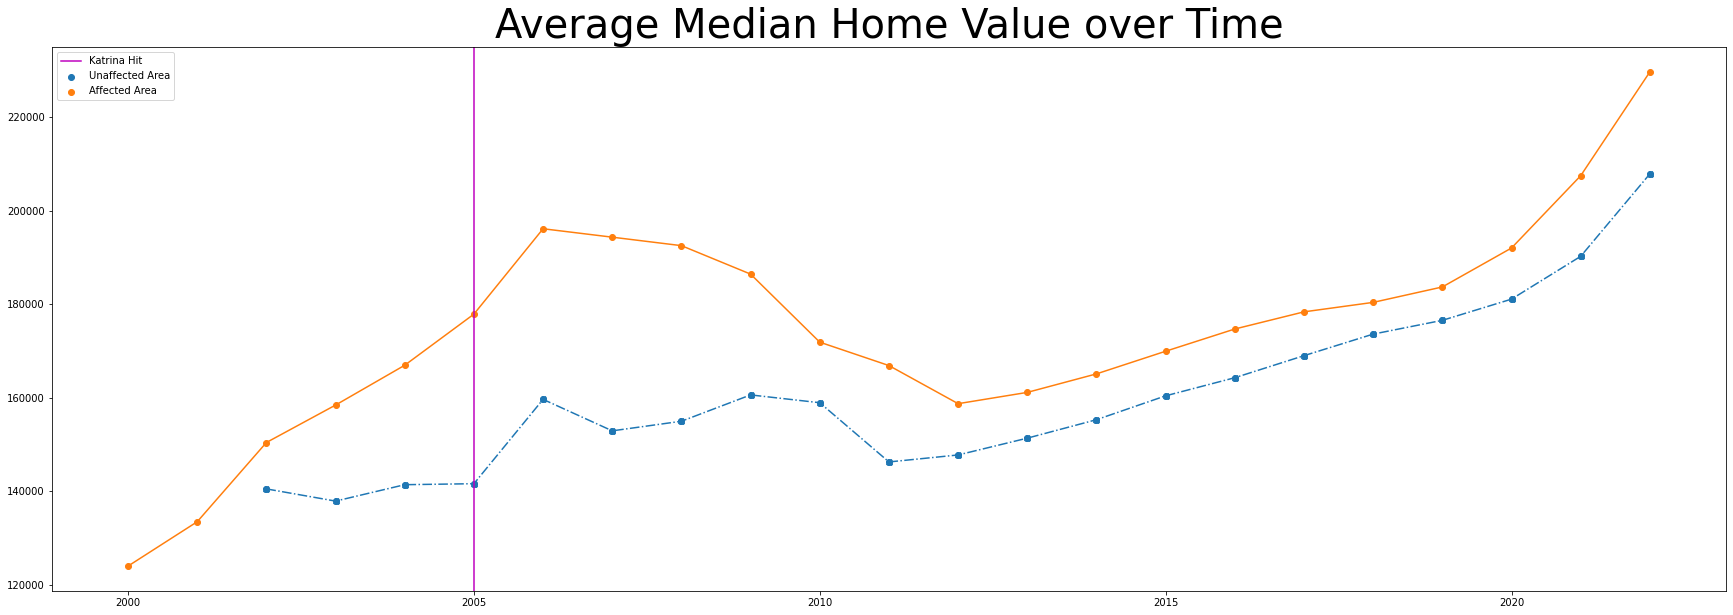

In [ ]:
x = all_data.index
y = all_data['ZHVI']
z = all_data['ZHVI_Unafected']
a = all_data['Median_income']
b = all_data['Median_income_Unafected']

fig, ax = plt.subplots(figsize=(30,10))
plt.scatter(x, z, label="Unaffected Area")
plt.plot(x, z, ls="-.",marker="X")

plt.scatter(x, y, label="Affected Area")
plt.plot(x, y, ls="-")
plt.axvline(x=2005,color = 'm',label = 'Katrina Hit')
plt.title("Average Median Home Value over Time",fontsize=40)
plt.legend()
plt.show()

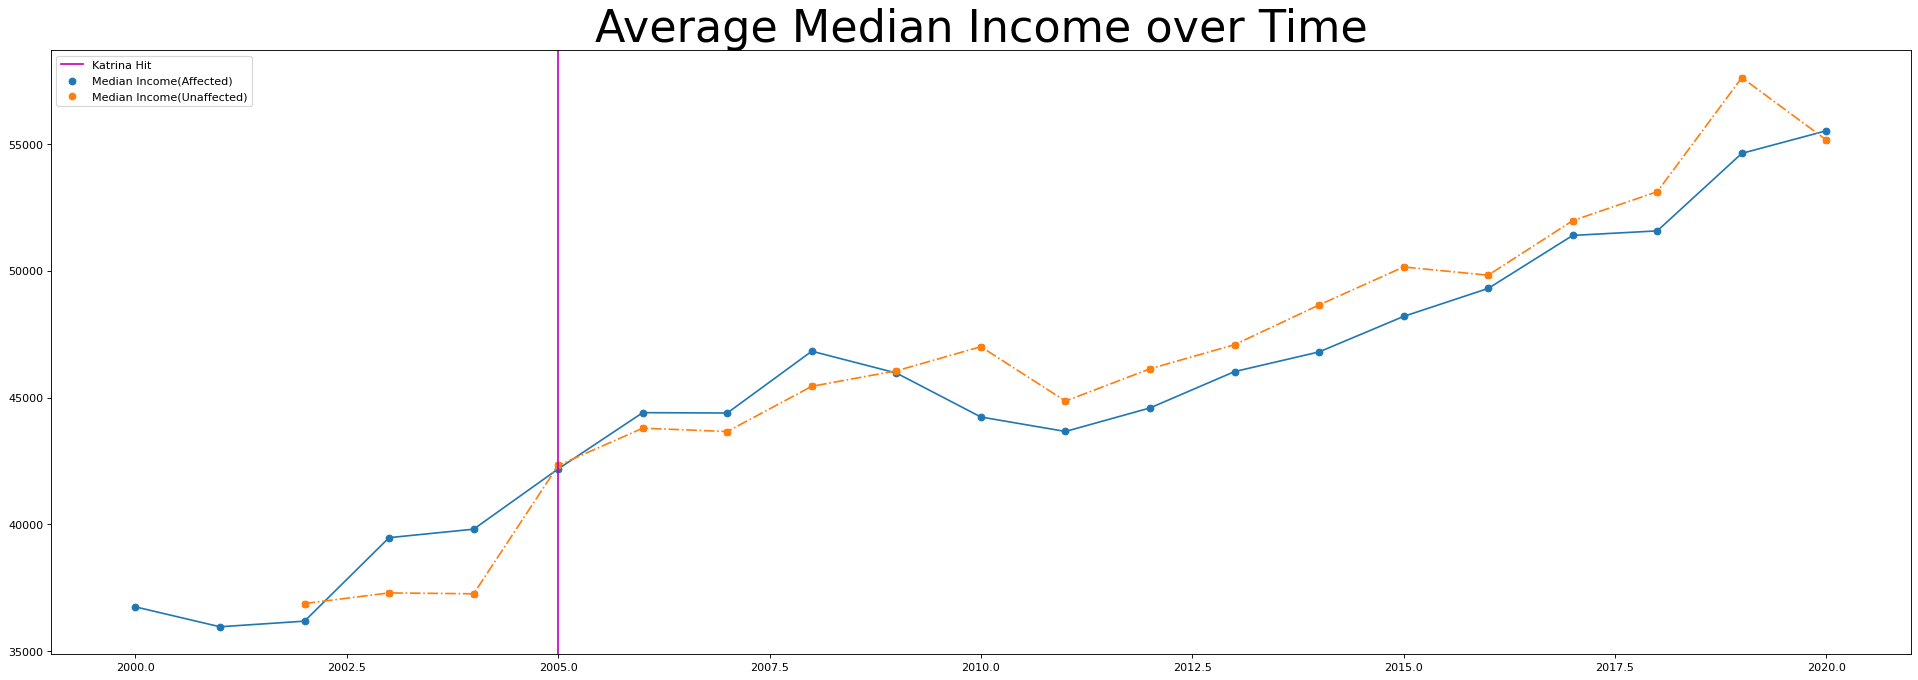

In [ ]:
figure(figsize=(30,10), dpi=80)
plt.scatter(x, a, label="Median Income(Affected)")
plt.plot(x, a, ls="-")

plt.scatter(x, b, label="Median Income(Unaffected)")
plt.plot(x, b, ls="-.",marker="X")
plt.axvline(x=2005,color = 'm',label = 'Katrina Hit')
plt.title("Average Median Income over Time",fontsize=40)
plt.legend()
plt.show()

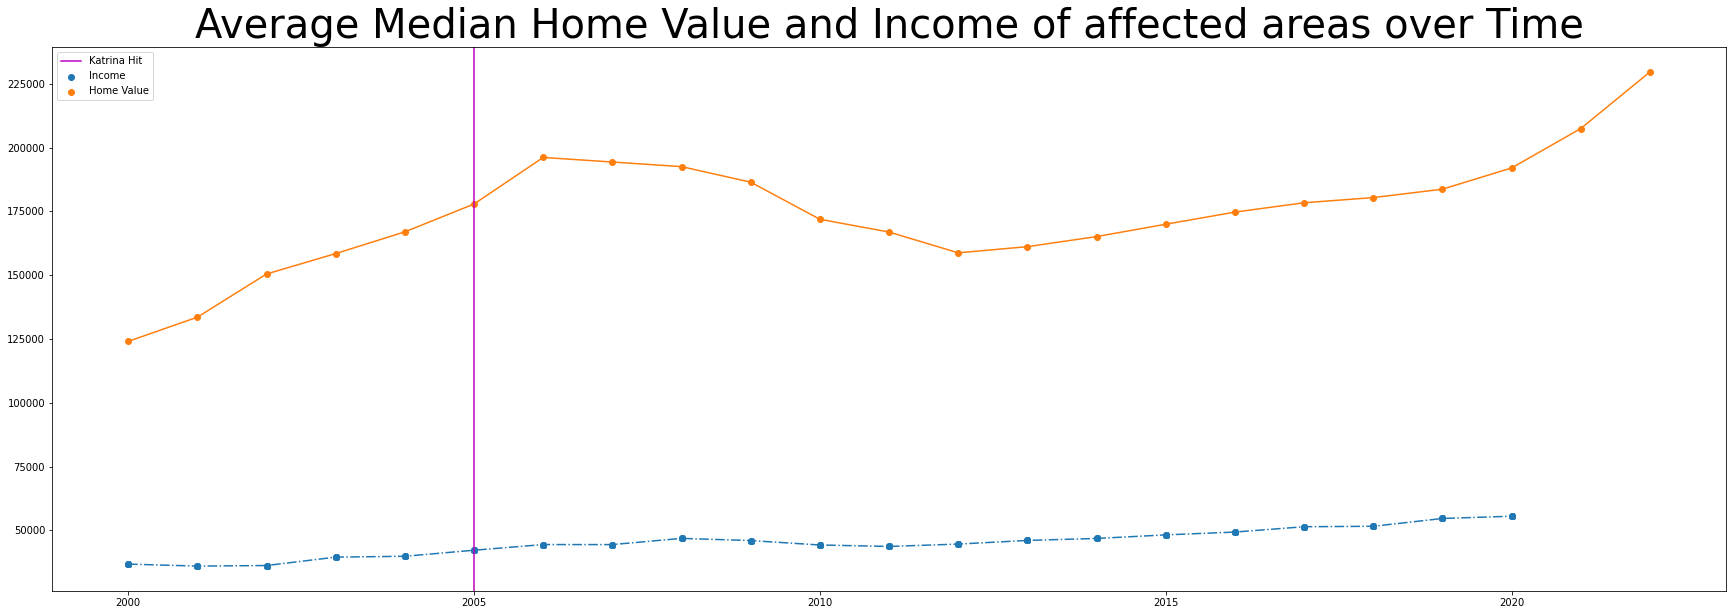

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))
plt.scatter(x, a, label="Income")
plt.plot(x, a, ls="-.",marker="X")

plt.scatter(x, y, label="Home Value")
plt.plot(x, y, ls="-")
plt.axvline(x=2005,color = 'm',label = 'Katrina Hit')
plt.title("Average Median Home Value and Income of affected areas over Time",fontsize=40)
plt.legend()
plt.show()

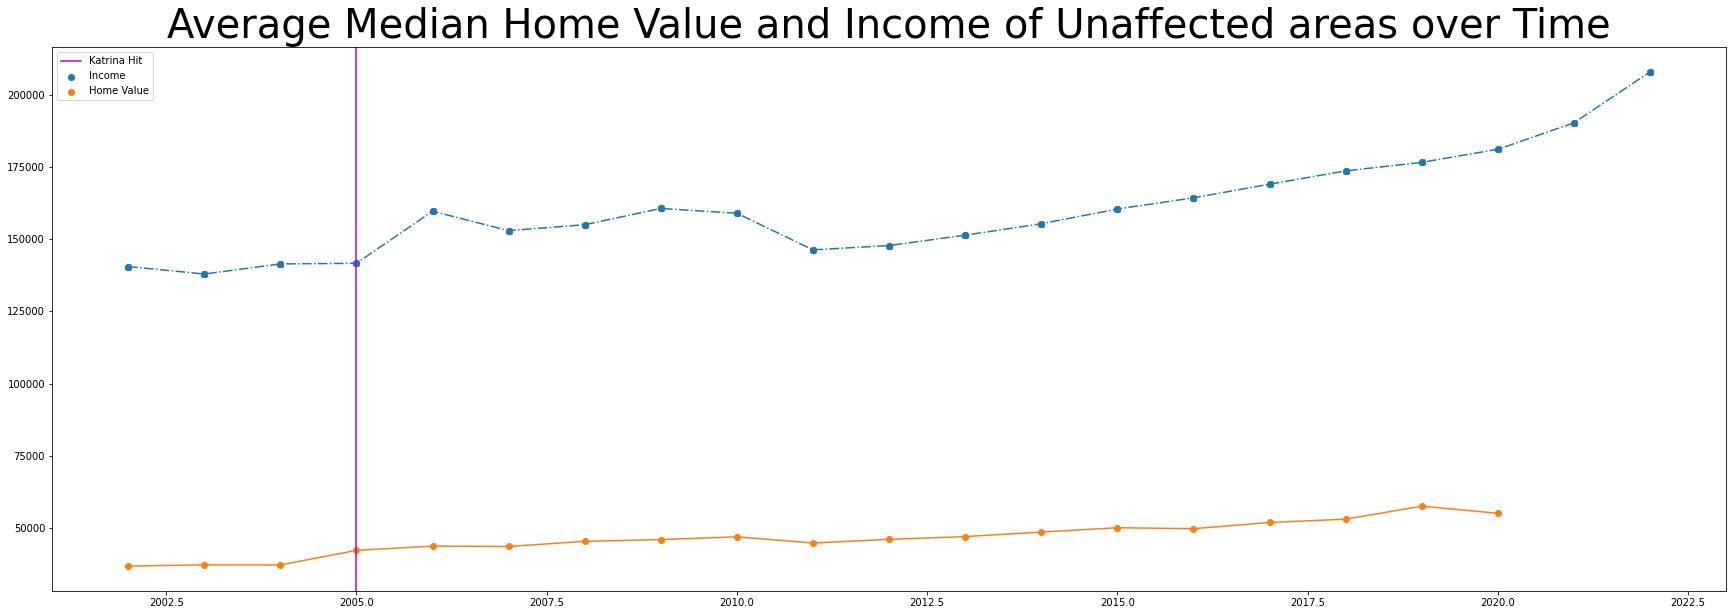

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))
plt.scatter(x, z, label="Income")
plt.plot(x, z, ls="-.",marker="X")

plt.scatter(x, b, label="Home Value")
plt.plot(x, b, ls="-")
plt.axvline(x=2005,color = 'm',label = 'Katrina Hit')
plt.title("Average Median Home Value and Income of Unaffected areas over Time",fontsize=40)
plt.legend()
plt.show()